In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Create a linear array with gaussian distribution as weights

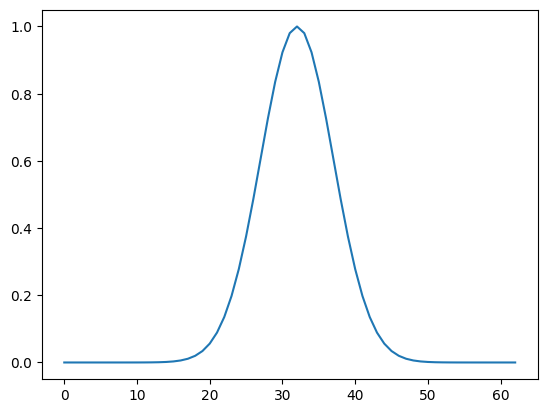

In [3]:
#some useful variables
R = 192
T = 64
N = 128
stddev = 5
weights = torch.arange(0, T-1, 1)
bins = torch.arange(0, T, 1)
weights = torch.exp(-(weights-T/2)**2/(2*stddev**2))

#expand the weights to the correct size
weights = weights.expand((R,T-1))
bins = bins.expand((R,T))

#visualize the weights
plt.plot(weights[0,:].detach().numpy())

## Compute cumulative probability distribution

torch.Size([192, 64])


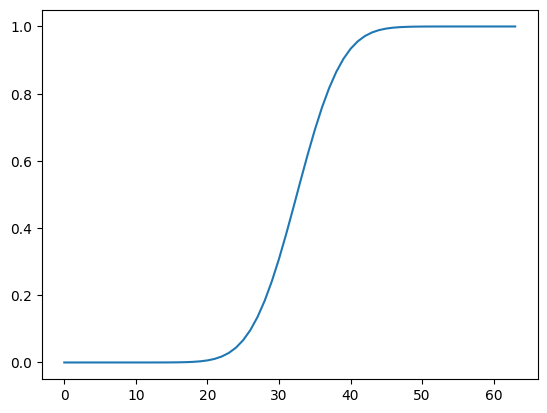

In [4]:
weights = weights + 1e-5
pdf = weights / torch.sum(weights, -1, keepdim=True)
cdf = torch.cumsum(pdf, -1)
cdf = torch.cat([torch.zeros_like(cdf[...,0:1]), cdf], dim=-1)
plt.plot(cdf[0].detach().numpy())
print(cdf.shape)

## Invert CDF

torch.Size([192, 128]) torch.Size([192, 128]) torch.Size([192, 128]) torch.Size([192, 128, 2])
torch.Size([192, 128, 2]) torch.Size([192, 128])
tensor(0) tensor(63)


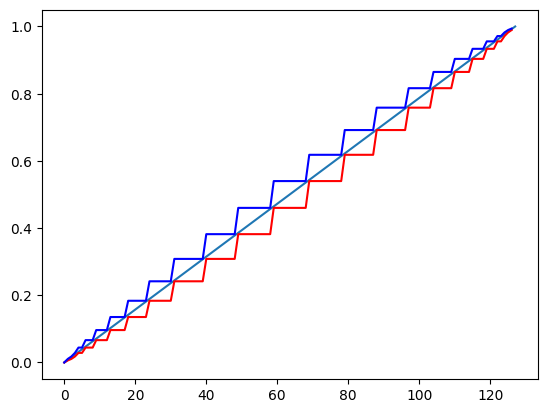

In [5]:
#sample uniformly between 0 and 1
u = torch.linspace(0., 1., steps=N)
u = u.expand(list(cdf.shape[:-1]) + [N])
u = u.contiguous()

# #figure out 
inds = torch.searchsorted(cdf, u, right=True)
below = torch.max(torch.zeros_like(inds-1), inds-1)
above = torch.min((cdf.shape[-1]-1) * torch.ones_like(inds), inds)
inds_g = torch.stack([below, above], -1)  # (batch, N_samples, 2)

print(inds.shape, below.shape, above.shape, inds_g.shape)
print(inds_g.shape, u.shape)
print(inds_g.min(), inds_g.max())

# #plot samples
plt.plot(u[0].detach().numpy())
plt.plot(cdf[0,below[0,:-1]].detach().numpy(), 'r')
plt.plot(cdf[0,above[0,:-1]].detach().numpy(), 'b')

## Gather CDF at the relevant indices

[192, 128, 64]
torch.Size([192, 128, 2]) torch.Size([192, 128, 2])


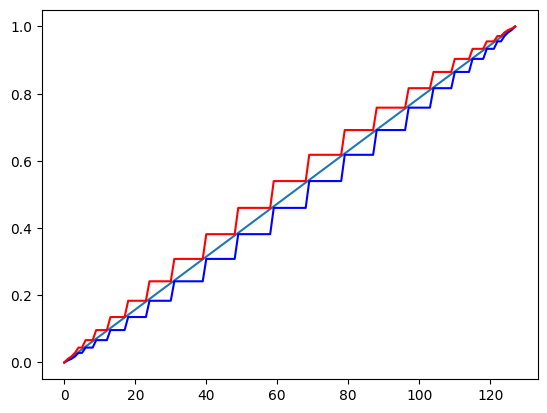

In [113]:
matched_shape = [inds_g.shape[0], inds_g.shape[1], cdf.shape[-1]]
print(matched_shape)

cdf_g = torch.gather(cdf.unsqueeze(1).expand(matched_shape), 2, inds_g)
bins_g = torch.gather(bins.unsqueeze(1).expand(matched_shape), 2, inds_g)
print(cdf_g.shape, bins_g.shape)
plt.plot(u[0].detach().numpy())
plt.plot(cdf_g[0,:,0].detach().numpy(), 'b')
plt.plot(cdf_g[0,:,1].detach().numpy(), 'r')

## Compute denominator

torch.Size([192, 128])


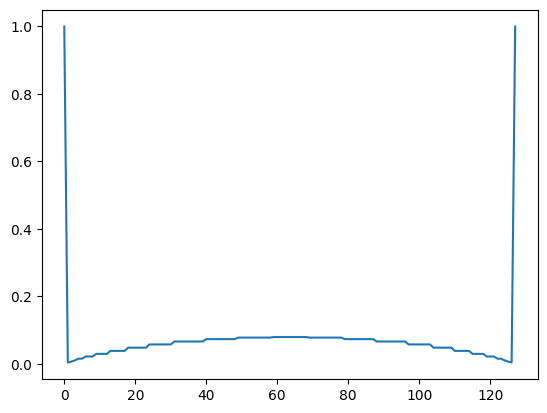

In [114]:
denom = (cdf_g[...,1]-cdf_g[...,0])
denom = torch.where(denom<1e-5, torch.ones_like(denom), denom)
plt.plot(denom[0].detach().numpy())
print(denom.shape)

## Compute new samples

torch.Size([192, 128])


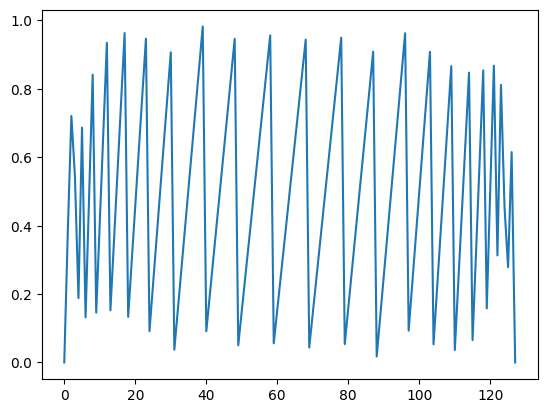

In [115]:
t = (u-cdf_g[...,0])/denom
print(t.shape)
plt.plot(t[0].detach().numpy())
samples = bins_g[...,0] + t * (bins_g[...,1]-bins_g[...,0])

## plot samples

<BarContainer object of 64 artists>

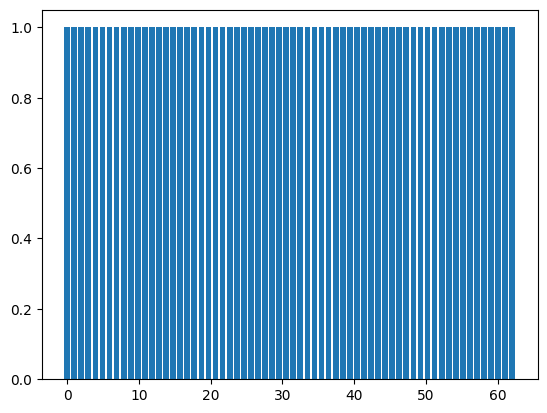

In [125]:
freq, bin_edges = np.histogram(bins[0].detach().numpy(), bins=64)
plt.bar(bin_edges[:-1], freq)

## plot samples

<BarContainer object of 64 artists>

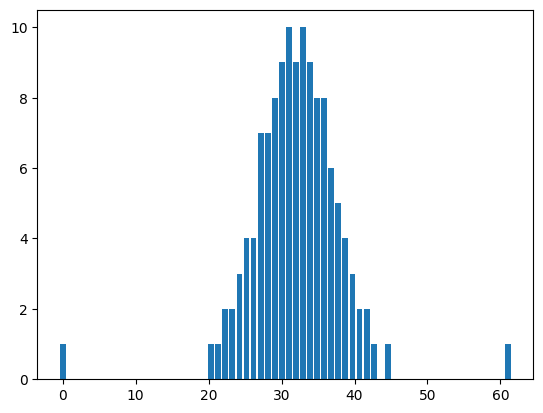

In [126]:
freq, bin_edges = np.histogram(samples[0].detach().numpy(), bins=64)
plt.bar(bin_edges[:-1], freq)

  0%|          | 0/79734 [00:00<?, ?it/s]

100%|██████████| 79734/79734 [25:22<00:00, 52.36it/s]


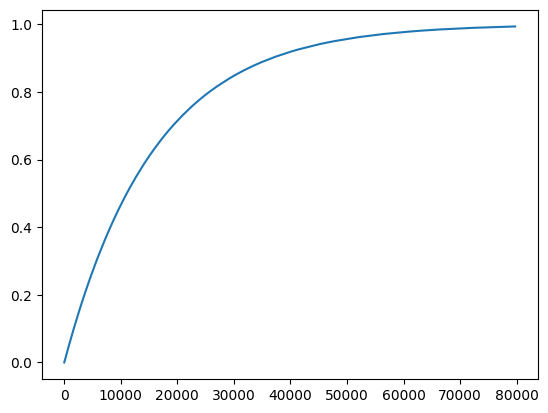

In [7]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

N = 540*960*126
B = 4096
iters = (5*N) // B

arr = np.zeros((N), np.bool_)

frac = []

for i in tqdm(range(iters)):
    samples = np.random.randint(low=0, high=N, size=(B))
    arr[samples] = True
    frac.append(np.sum(arr)/N)

plt.plot(frac)

In [10]:
print(N-frac[-1]*N)

440358.0
